# ktree

Code up ktree and train on binary classification functions

In [1]:
import customrnn as cr

from custompackage.load_data import *
from custompackage.load_architecture import *
from custompackage.traintestloop import *
from custompackage.neuron_capacity import *
from custompackage.sin_ineq import *

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import numpy as np
import math
import torchvision
from torchvision import transforms
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import matplotlib
import matplotlib.pyplot as plt
from torch.optim.optimizer import required
from torch.utils.data.dataset import random_split
import scipy
import os
import glob
import pandas as pd
from hyperopt import hp, tpe, fmin, Trials
import pickle

% matplotlib inline

In [2]:
torch.cuda.set_device(2)
torch.cuda.current_device()


2

# Prepare binary classification dataset

Which class of cifar10 is most difficult to linearly classify?

I recall that it is 2 and 4 (53%), but we can use 2 and 3 instead (60%)


In [3]:
Batchsize=256
Target_1=2
Target_2=3
Data_weighting='paired'
Split=10
ds='cifar10'



trainloaders, validloaders, testloader = dataset_weighted_split(Batchsize,
                                                                Target_1,
                                                                Target_2,
                                                                Data_weighting,
                                                                Split,
                                                                ds)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
scores = np.zeros(Split)

for i in range(Split):
    
    
    trainloader = trainloaders[i]

    x_train = trainloader.dataset.tensors[0]
    y_train = trainloader.dataset.tensors[1]
    x_test = testloader.dataset.tensors[0]
    y_test = testloader.dataset.tensors[1]

    lda = LinearDiscriminantAnalysis()
    lda.fit(x_train, y_train)

    scores[i] = lda.score(x_test,y_test)



/home/ilenna/.conda/envs/py36_mod2/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [6]:
a = np.load('./results/20200316/acc_linear.npy')
np.mean(a)

0.5779

In [58]:
# np.save('./results/20200316/acc_linear', scores)

# Prepare ktree architecture

In [2]:
class ktree_cifar10(nn.Module):
    '''
    Tree NN
    '''
    
    def __init__(self, Activation="relu", Sparse=True,
                 Input_order=None, Repeats=1):
        super(ktree_cifar10, self).__init__()
        '''
        Inputs: Input_size, Hidden_size, Output_size
        '''
        # Initialize architecture parameters
        self.Activation = Activation
        self.Sparse = Sparse
        self.Input_order = Input_order
        self.Repeats = Repeats
        
        # Initialize weights
        # Set biases to 0
        # Set kaiming initialize weights with gain to correct for sparsity
        # Set freeze masks
        self.k = [3072, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
        self.names = np.empty((self.Repeats, len(self.k)-1),dtype=object)
        self.freeze_mask_set = []
        for j in range(self.Repeats):
            for i in range(len(self.k)-1):
                name = ''.join(['w',str(j),'_',str(i)])
                self.add_module(name, nn.Linear(self.k[i],self.k[i+1]))
                self._modules[name].bias = nn.Parameter(torch.zeros_like(self._modules[name].bias)) 
                self._modules[name].weight.data, freeze_mask = self.initialize(self._modules[name])
                self.names[j,i] = name
                if j < 1:
                    self.freeze_mask_set.append(freeze_mask)
        
        self.root = nn.Linear(Repeats, 1)
        
        # Initialize nonlinearities
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        '''
        Forward step for network. Establishes Architecture.
        Inputs: Input, Hidden
        Outputs: Output, Hidden
        '''
        
        y_out = []
        for j in range(self.Repeats):
            y = x
            for i in range(len(self.k)-1):
                if self.Activation == 'relu':
                    y = self.relu(self._modules[self.names[j,i]](y))
                else:
                    y = self._modules[self.names[j,i]](y)
            y_out.append(y)

        output = self.sigmoid(self.root(torch.cat((y_out), dim=1)))

        return(output)
    
    
model = ktree_cifar10(Sparse=False,Repeats=2).cuda()

a = torch.ones((1,3072)).cuda()
model(a)



tensor([[0.5582]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [ ]:


# model = ktree_cifar10(Repeats=2)

# # k = [3072, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
# # names=[]
# # for j in range(2):
# #     for i in range(11):
# #         a = 'w'+str(j)+'_'+str(i)
# #         model.add_module(a, nn.Linear(k[i],k[i+1]))
# #         names.append(a)
# x = torch.ones((1,3072))

# k = [3072, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
# names = np.empty((model.Repeats, len(k)-1),dtype=object)
# for j in range(model.Repeats):
#     for i in range(len(k)-1):
#         name = ''.join(['w',str(j),'_',str(i)])
#         model.add_module(name, nn.Linear(k[i],k[i+1]))
#         model._modules[name].bias = nn.Parameter(torch.zeros_like(model._modules[name].bias)) 
#         model._modules[name].weight.data, freeze = model.initialize(model._modules[name])
#         names[j,i] = name


# y_out = []
# for j in range(model.Repeats):
#     y = x
#     for i in range(len(k)-1):
#         y = model._modules[names[j,i]](y)
# #         print(y)
#     y_out.append(y)

# output = model.sigmoid(model.roottorch.cat((y_out), dim=1)
# print(y_out)
# # int(names[0][1])
# # model._modules[names[1]]
# # model.named_modules

# Train and test new model - can it learn?

In [122]:
def train_test_ktree(model, trainloader, testloader, epochs=10):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    loss_curve = []
    acc_curve = []
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_acc = 0.0

        for i, data in enumerate(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, _ = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().reshape(-1,1))
            loss.backward()
            
####        # Freeze select weights by zeroing out gradients
            for child in model.children():
                for param in child.parameters():
                    for freeze_mask in model.freeze_mask_set:
                        if param.grad.shape == freeze_mask.shape:
                            param.grad[freeze_mask] = 0
            
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            running_acc += (torch.round(outputs) == labels.float().reshape(-1,1)).sum().item()/trainloader.batch_size
            if (i % 4) == 3:    # print every 80 mini-batches
                loss_curve.append(running_loss/3)
                acc_curve.append(running_acc/3)
                running_loss = 0.0

    print('Finished Training, %d epochs' % (epoch+1))
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels, _ = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels.float().reshape(-1,1))
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels.float().reshape(-1,1)).sum().item()

    accuracy = correct/total
    
    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * accuracy))
        
    return(loss_curve, acc_curve, loss, accuracy, model)

In [3]:
Batchsize=256
Target_1=2
Target_2=3
Data_weighting='paired'
Split=10
ds='cifar10'


trainloaders, validloaders, testloader = dataset_weighted_split(Batchsize,
                                                                Target_1,
                                                                Target_2,
                                                                Data_weighting,
                                                                Split,
                                                                ds)


Files already downloaded and verified
Files already downloaded and verified


Finished Training, 5000 epochs
Accuracy of the network on the 10000 test images: 63 %


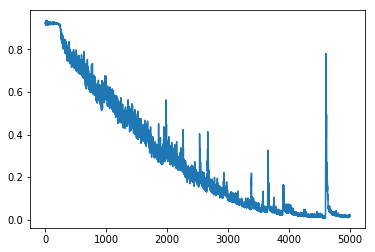

In [75]:
model = ktree_cifar10(Repeats=2).cuda()


loss_curve, acc_curve, acc, loss, model_t = train_test_ktree(model, trainloaders[0],
                                      validloaders[0], epochs = 5000)

plt.plot(loss_curve)



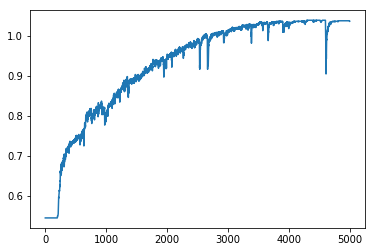

In [76]:
plt.plot(acc_curve)

Finished Training, 500 epochs
Accuracy of the network on the 10000 test images: 66 %


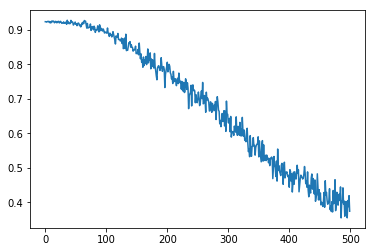

In [4]:
model = ktree_cifar10(Repeats=8).cuda()


loss_curve, acc_curve, acc, loss, model_t = train_test_ktree(model, trainloaders[0],
                                      validloaders[0], epochs = 500)

plt.plot(loss_curve)



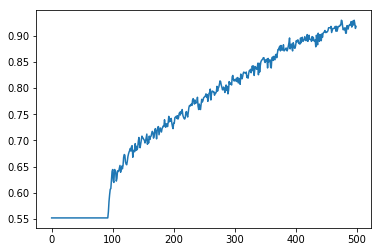

In [5]:
plt.plot(acc_curve)

# FC Network

In [51]:
def train_test_fc(model, trainloader, testloader, epochs=10):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    loss_curve = []
    acc_curve = []
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_acc = 0.0

        for i, data in enumerate(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, _ = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().reshape(-1,1))
            loss.backward()
            
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            running_acc += (torch.round(outputs) == labels.float().reshape(-1,1)).sum().item()/trainloader.batch_size
            if i % 4 == 3:    # print every 80 mini-batches

                loss_curve.append(running_loss/3)
                acc_curve.append(running_acc/3)
                running_loss = 0.0
                running_acc = 0.0

    print('Finished Training, %d epochs' % (epoch+1))
    
    correct = 0
    all_loss = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels, _ = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels.float().reshape(-1,1))
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels.float().reshape(-1,1)).sum().item()
            all_loss += loss
    accuracy = correct/total
    ave_loss = all_loss.item()/total
    
    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * accuracy))
        
    return(loss_curve, acc_curve, ave_loss, accuracy, model)

In [32]:
class simple_fcnn(nn.Module):
    '''
    2 layer feed forward neural network. 
    Will code in Linear, Sigmoid, or ReLU activation functions.
    Activation = {'relu', 'sigmoid', 'linear'}
    '''
    
    def __init__(self, Input_size=3072, Hidden_size=3072, Output_size=1, Activation="relu"):
        super(simple_fcnn, self).__init__()
        '''
        Inputs: Input_size, Hidden_size, Output_size
        '''
        # Initialize architecture parameters
        self.Input_size = Input_size
        self.Hidden_size = Hidden_size
        self.Output_size = Output_size
        self.Activation = Activation
        
        
        # Initialize weights through He initialization (by default in nn.Linear)
        
        self.i2h = nn.Linear(Input_size, Hidden_size, bias=True)
        self.i2h.bias = torch.nn.Parameter(torch.zeros_like(self.i2h.bias))
        self.i2h.weight = torch.nn.init.normal_(self.i2h.weight, mean=0.0, std=math.sqrt(2/(Input_size)))
            

        # Initialize densly connected output layer
        self.h2o = nn.Linear(Hidden_size, Output_size)
        self.h2o.bias = torch.nn.Parameter(torch.zeros_like(self.h2o.bias))
        self.h2o.weight = torch.nn.init.kaiming_normal_(self.h2o.weight, a=0.01)
        
        # Initialize nonlinearities
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        '''
        Forward step for network. Establishes Architecture.
        Inputs: Input, Hidden
        Outputs: Output, Hidden
        '''
        # Prepare input for appropriate architecture

        
        # Set Activation function to calculate hidden layer

        if self.Activation == 'relu':
            Hidden = self.relu(self.i2h(x))
        else:
            Hidden = self.i2h(x)

        # Calculate Output layer
        Output = self.sigmoid(self.h2o(Hidden))
        return(Output)

Finished Training, 100 epochs
Accuracy of the network on the 10000 test images: 70 %


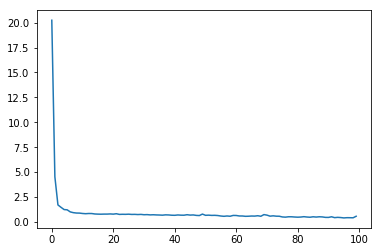

In [39]:
model = simple_fcnn(3072, 3072, 1).cuda()


loss_curve, acc_curve, loss, acc, model_t = train_test_fc(model, trainloaders[0],
                                      validloaders[0], epochs = 100)

plt.plot(loss_curve)



100
0.6649305555555556


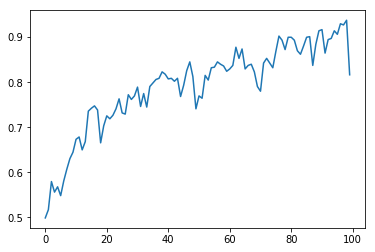

In [40]:
plt.plot(acc_curve)
print(len(acc_curve))
print(acc_curve[0]*4/3)

# Hyperparameter optimization script

In [ ]:
# # Testing 1tree relu
# def objective(space):
#     # Objective function will contain architecture and dataset    
    
#     ds = 'cifar10'
    
#     lr = space['lr']
#     bs = int(space['bs'])
    
#     trials = 10
#     epochs = 5000
    
#     target_1 = 2
#     target_2 = 3

#     train_loaders, valid_loaders, test_loader = dataset_weighted_split( Batch_size=bs,
#                                                                         Target_class_1=target_1,
#                                                                         Target_class_2=target_2,
#                                                                         Data_weighting='paired',
#                                                                         Split=trials,
#                                                                         ds=ds)
    
#     # Select archetype to run
#     model = ktree_cifar10(Repeats=1).cuda()

#     loss_curve, acc_curve, acc, loss, model_t = train_test_ktree(model, trainloaders[0],
#                                           test_loader, epochs = epochs)
        
#     # Output will be test_loss
#     return loss

# space = {
#         'lr' : hp.loguniform('lr', -6, -3),
#         'bs' :  hp.qloguniform('bs', 1, 6, 1),
# }

# #Create tpe algorithm (Tree Parzen Estimator)
# tpe_algo = tpe.suggest

# # Create Trials Object
# tpe_trials = Trials()

# # Run the optimization
# tpe_best = fmin(fn=objective, 
#                 space=space, 
#                 algo=tpe_algo, 
#                 trials=tpe_trials, 
#                 max_evals=20, 
#                 rstate= np.random.RandomState(50))

# DIR = "./results/20200312/"
# filename = 'hyperopt_1tree_relu.p'

# pickle.dump(tpe_trials, open(os.path.join(DIR, filename), "wb"))


In [ ]:
# # Testing fc network
# # Testing 1tree relu
# def objective(space):
#     # Objective function will contain architecture and dataset    
    
#     ds = 'cifar10'
    
#     lr = space['lr']
#     bs = int(space['bs'])
    
#     trials = 10
#     epochs = 500
    
#     target_1 = 2
#     target_2 = 3

#     train_loaders, valid_loaders, test_loader = dataset_weighted_split( Batch_size=bs,
#                                                                         Target_class_1=target_1,
#                                                                         Target_class_2=target_2,
#                                                                         Data_weighting='paired',
#                                                                         Split=trials,
#                                                                         ds=ds)
    
#     # Select archetype to run
#     model = simple_fcnn(3072, 3072, 1, Density=1).cuda()
#     model = model.cuda()

#     loss_curve, acc_curve, loss, acc, model_t = train_test_fc(model, trainloaders[0],
#                                           validloaders[0], epochs = 500)
        
#     # Output will be test_loss
#     return loss

# space = {
#         'lr' : hp.loguniform('lr', -6, -3),
#         'bs' :  hp.qloguniform('bs', 1, 6, 1),
# }

# #Create tpe algorithm (Tree Parzen Estimator)
# tpe_algo = tpe.suggest

# # Create Trials Object
# tpe_trials = Trials()

# # Run the optimization
# tpe_best = fmin(fn=objective, 
#                 space=space, 
#                 algo=tpe_algo, 
#                 trials=tpe_trials, 
#                 max_evals=20, 
#                 rstate= np.random.RandomState(50))

# DIR = "./results/20200312/"
# filename = 'hyperopt_fcnn_relu.p'

# pickle.dump(tpe_trials, open(os.path.join(DIR, filename), "wb"))


0


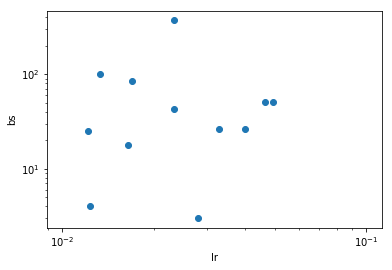

lr: 0.04921849151558738 
bs: 51.0


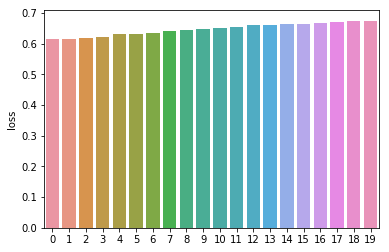

In [67]:
tpe_trials = pickle.load(open('./results/20200312/hyperopt_1tree_relu.p', "rb"))

tpe_results = pd.DataFrame({'loss': [x['loss'] for x in tpe_trials.results], 
                            'iteration': tpe_trials.idxs_vals[0]['lr'],
                            'lr': tpe_trials.idxs_vals[1]['lr'],
                            'bs': tpe_trials.idxs_vals[1]['bs']})

a = tpe_results.sort_values('loss')

print(sum(a.loss>5))

fig = plt.figure()
ax = plt.gca()
ax.scatter(tpe_results['lr'], 
           tpe_results['bs'])
# ax.scatter(a['lr'][0], a['bs'][0])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('lr')
ax.set_ylabel('bs')
plt.show()

b = tpe_results.sort_values('loss').reset_index(drop=True)

import seaborn as sns

ax = sns.barplot(b.index, b.loss)

print('lr:', a['lr'][0],'\nbs:', a['bs'][0])

0


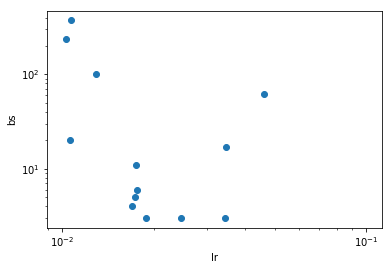

lr: 0.017441287476831522 
bs: 11.0


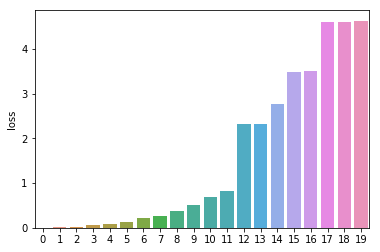

In [43]:
tpe_trials = pickle.load(open('./results/20200312/hyperopt_fcnn_relu.p', "rb"))

tpe_results = pd.DataFrame({'loss': [x['loss'] for x in tpe_trials.results], 
                            'iteration': tpe_trials.idxs_vals[0]['lr'],
                            'lr': tpe_trials.idxs_vals[1]['lr'],
                            'bs': tpe_trials.idxs_vals[1]['bs']})

a = tpe_results.sort_values('loss')

print(sum(a.loss>5))

fig = plt.figure()
ax = plt.gca()
ax.scatter(tpe_results['lr'], 
           tpe_results['bs'])
# ax.scatter(a['lr'][0], a['bs'][0])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('lr')
ax.set_ylabel('bs')
plt.show()

b = tpe_results.sort_values('loss').reset_index(drop=True)

import seaborn as sns

ax = sns.barplot(b.index, b.loss)
i = 0
print('lr:', a['lr'][i],'\nbs:', a['bs'][i])

# Script for testing k-trees - plotting ktree accuracy

In [ ]:
Batchsize=256
Target_1=2
Target_2=3
Data_weighting='paired'
trials=10
ds='cifar10'

epochs = 5000

trees_set = [1,2,4,8,16,32]

acc = np.zeros((trials, len(trees_set)))
loss = np.zeros((trials, len(trees_set)))


trainloaders, validloaders, testloader = dataset_weighted_split(Batchsize,
                                                                Target_1,
                                                                Target_2,
                                                                Data_weighting,
                                                                trials,
                                                                ds)

for i in range(trials):
    for j, trees in enumerate(trees_set):
        print(i, j)
        model = ktree_cifar10(Repeats=trees).cuda()


        loss_curve, acc_curve, loss[i,j], acc[i,j] model_t = train_test_ktree(model, trainloaders[i],
                                              testloader, epochs = 5000)
        
        np.save('./results/20200316/k_tree_acc.npy', acc)
        np.save('./results/20200316/k_tree_loss.npy', loss)


# Testing fc tree

In [ ]:
Batchsize=256
Target_1=2
Target_2=3
Data_weighting='paired'
trials = 10
ds='cifar10'

acc = np.zeros((trials))
loss = np.zeros((trials))

trainloaders, validloaders, testloader = dataset_weighted_split(Batchsize,
                                                                Target_1,
                                                                Target_2,
                                                                Data_weighting,
                                                                trials,
                                                                ds)


for i in range(trials):
    print(i)

    model = simple_fcnn(3072, 3072, 1).cuda()


    loss_curve, acc_curve, loss[i], acc[i], model_t = train_test_fc(model, trainloaders[i],
                                          validloaders[i], epochs = 500)


    np.save('./results/20200316/fc_acc.npy', acc)
    np.save('./results/20200316/fc_loss.npy', loss)

